# Binary & Multi-Class Classification Demonstrations

As a clothing retailer with an e-Commerce presence, it's important for us to understand what customers are saying about our products, which products are most popular with our customers, and how we can improve our offerings.



## Binary Classifcation

**Recommendation Prediction**: We will use the text from customer reviewsto understand better if a customer will give a positive rating on the clothing items based on their review.

In [1]:
# Gereral Imports
import numpy as np
import pandas as pd
import re
import string
from collections import Counter
from timeit import timeit
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.multiclass import OneVsRestClassifier

# XGBoost
import xgboost as xgb

# Model Persistence Imports
from joblib import dump, load

# Test Processing Imports
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

# SMOTE Imports
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Plotting Imports
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing & EDA

Importing our dataset and providing the necessary cleaning and analysis.

In [2]:
df = pd.read_csv("ClothingReviews.csv")
df.head()

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,Class Name
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimate,Intimates
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,Dresses
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Tops,Blouses


In [3]:
# add a column for positive or negative
df['Target'] = df['Rating'].apply(lambda c: 0 if c < 4 else 1)

## Data Cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      23486 non-null  int64 
 1   Title                    19676 non-null  object
 2   Review Text              22641 non-null  object
 3   Rating                   23486 non-null  int64 
 4   Recommended IND          23486 non-null  int64 
 5   Positive Feedback Count  23486 non-null  int64 
 6   Department Name          23472 non-null  object
 7   Class Name               23472 non-null  object
 8   Target                   23486 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 1.6+ MB


In [5]:
df.shape

(23486, 9)

### Null Values

Nulll values are generally not desireable in a dataset.  In certain cases, observations (rows) with low counts will simply be dropped, in other cases, they can be filled with other values.

In [6]:
# fill the NA values with empty string so that we don't drop rows that are only missing a title
df['Title'].fillna('', inplace=True)

In [7]:
# count of nulls
df.isnull().sum()

Age                          0
Title                        0
Review Text                845
Rating                       0
Recommended IND              0
Positive Feedback Count      0
Department Name             14
Class Name                  14
Target                       0
dtype: int64

In [8]:
df.dropna(inplace=True)

In [9]:
df['Text'] = df['Title'] + ' ' + df['Review Text']

In [10]:
# Add column 'text_len' that counts the length for the derived field
df['text_len'] = df.apply(lambda row: len(row['Text']), axis = 1)

In [11]:
df.drop(columns=['Title', 'Review Text'], inplace=True)

### Duplicates

A common practice is to review any duplicates.  If there are large quantities, they can skew the results.

In [12]:
len_before = df.shape[0]
df.drop_duplicates(inplace=True)
len_after = df.shape[0]

print("Before =", len_before)
# drop duplicates
print("After =", len_after)
print('')
print("Total Removed =", len_before - len_after)

Before = 22628
After = 22626

Total Removed = 2


## Check for Imbalanced Data

In [13]:
df['Target'].value_counts()

1    17433
0     5193
Name: Target, dtype: int64

## Text Cleaning

For **Parts** of our analysis, the text needs to have some basic transformation for our models to work propertly.  These are as follows:

1. **Lower**: Convert all characters to lowercase
1. **Remove Punctuation**: In most cases, punctuation doesn't help NLP and ML models and can be removed.
1. **Stop Word Removal**: Stop words generally don't add context to analysis (unless the length of text is very short (`100` - `200` characters) and can be removed.
1. **Lemmatization**: Words will be reduced to there *Lemma* or root.  This will greatly improve the accuracy of the analysis since words like `simming` and `swimmer` will be reduced to `swim`.

**Note**: The orginal text will be preserved for other analysis.

In [14]:
df['Text'][1]

' Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.'

In [15]:
def process_string(text):
    
    final_string = ""
    
    # Convert the text to lowercase
    text = text.lower()
    
    # Remove punctionation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words and usless words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub('\w*\d\w*', '', w) for w in text_filtered]
    
    # Stem the text with NLTK PorterStemmer
    stemmer = PorterStemmer() 
    text_stemmed = [stemmer.stem(y) for y in text_filtered]

    # Join the words back into a string
    final_string = ' '.join(text_stemmed)
    
    return final_string

In [16]:
df['Text_Processed'] = df['Text'].apply(lambda x: process_string(x))

In [17]:
df['Text_Processed'][1]

'love dress sooo pretti happen find store im glad bc never would order onlin bc petit bought petit  love length hit littl knee would definit true midi someon truli petit'

# Sentiment Based Prediction Model:

Next, we'll create a Supervised ML model to predict whether a customer will recommend a product based on the text from the review and the sentiment of that text, and the length of the review.

To create our model, we will be mixing both text and numeric values.  There are multiple ways to accomplish this, but we will be using a `ColumnTransformer` in a Pipeline.

## Pipeline Building

In [18]:
def create_pipe(clf):
    '''Create a pipeline for a given classifier.  The classifier needs to be an instance
    of the classifier with all parmeters needed specified.'''
    
    # Each pipeline uses the same column transformer.  
    column_trans = ColumnTransformer(
            [('Text', TfidfVectorizer(), 'Text_Processed'),
             ('Text Length', MinMaxScaler(), ['text_len'])],
            remainder='drop') 
    
    pipeline = Pipeline([('prep',column_trans),
                         ('clf', clf)])
     
    return pipeline

## Model Selection via Cross-Validation

In [19]:
X = df[['Text_Processed', 'text_len']]
y = df['Target']

In [20]:
print(X.shape)
print(y.shape)

(22626, 2)
(22626,)


In [21]:
# count examples in each class
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 0.298


In [22]:
models = {'LogReg' : LogisticRegression(random_state=42, 
                                        class_weight='balanced', 
                                        max_iter=500),
          'RandomForest' : RandomForestClassifier(
                                        class_weight='balanced', 
                                        random_state=42),
          'XGBoost' : xgb.XGBClassifier(random_state=42, 
                                        verbosity=0, 
                                        scale_pos_weight=estimate)
          }

for name, model, in models.items():
    clf = model
    pipeline = create_pipe(clf)
    cv = RepeatedStratifiedKFold(n_splits=10, 
                                 n_repeats=3, 
                                 random_state=1)
    %time scores = cross_val_score(pipeline, X, y, scoring='f1_weighted', cv=cv, n_jobs=1, error_score='raise')
    print(name, ': Mean f1 Weighted: %.3f and Standard Deviation: (%.3f)' % \
        (np.mean(scores), np.std(scores)))

CPU times: user 21.7 s, sys: 7.78 s, total: 29.4 s
Wall time: 15.6 s
LogReg : Mean f1 Weighted: 0.878 and Standard Deviation: (0.005)
CPU times: user 3min 1s, sys: 2.57 s, total: 3min 4s
Wall time: 3min 4s
RandomForest : Mean f1 Weighted: 0.824 and Standard Deviation: (0.008)
CPU times: user 7min 38s, sys: 1min 9s, total: 8min 47s
Wall time: 1min 13s
XGBoost : Mean f1 Weighted: 0.867 and Standard Deviation: (0.006)


## Model Training

In [23]:
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=53)

In [24]:
print(y_train.value_counts())
print(y_test.value_counts())

1    11681
0     3478
Name: Target, dtype: int64
1    5752
0    1715
Name: Target, dtype: int64


## Model Validation

In [25]:
def fit_and_print(pipeline, name):
    ''' take a supplied pipeline and run it against the train-test spit 
    and product scoring results.'''
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(metrics.classification_report(y_test, y_pred, digits=3))
    
    print("Matthew's correlation coefficient (MCC)")
    print(metrics.matthews_corrcoef(y_test, y_pred))
    
    print("Brier Score Loss")
    print(metrics.brier_score_loss(y_test, y_pred))
        
    ConfusionMatrixDisplay.from_predictions(y_test, 
                                            y_pred, 
                                            cmap=plt.cm.YlOrBr)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('classification_' + name + '.png', dpi=300)  

              precision    recall  f1-score   support

           0      0.887     0.394     0.545      1715
           1      0.845     0.985     0.910      5752

    accuracy                          0.849      7467
   macro avg      0.866     0.689     0.727      7467
weighted avg      0.855     0.849     0.826      7467

Matthew's correlation coefficient (MCC)
0.5264265598029625
Brier Score Loss
0.1507968394268113


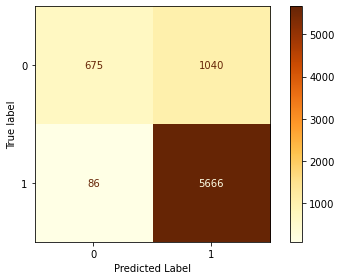

In [26]:
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
pipeline = create_pipe(clf)
fit_and_print(pipeline, 'RF')

              precision    recall  f1-score   support

           0      0.681     0.855     0.758      1715
           1      0.953     0.881     0.915      5752

    accuracy                          0.875      7467
   macro avg      0.817     0.868     0.837      7467
weighted avg      0.891     0.875     0.879      7467

Matthew's correlation coefficient (MCC)
0.68283669338406
Brier Score Loss
0.12535154680594615


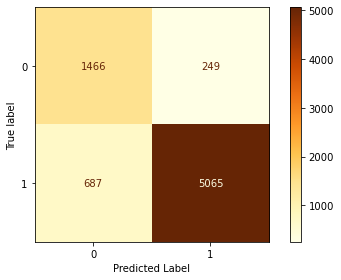

In [27]:
clf = LogisticRegression(random_state=42, 
                         class_weight='balanced', 
                         max_iter=500)
pipeline = create_pipe(clf)
fit_and_print(pipeline, 'LogReg')

Matthew’s correlation coefficient (MCC)

>“The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary (two-class) classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction. The statistic is also known as the phi coefficient.”

https://towardsdatascience.com/evaluation-metrics-leave-your-comfort-zone-and-try-mcc-and-brier-score-86307fb1236a

## Persist the Model

In [28]:
dump(pipeline, 'binary.joblib') 

['binary.joblib']

## Test on Custom Data

In [29]:
# Load the model
pipeline = load('binary.joblib')

In [30]:
def create_test_data(x):
    
    x = process_string(x)
    length = len(x)
    
    d = {'Text_Processed' : x,
        'text_len' : length}

    df = pd.DataFrame(d, index=[0])
    
    return df

In [31]:
revs = ['This dress is gorgeous and I love it and would gladly reccomend it to all of my friends.',
        'This skirt has really horible quality and I hate it!',
        'A super cute top with the perfect fit.',
        'The most gorgeous pair of jeans I have seen.',
        'this item is too little and tight.']

In [32]:
print('Returns 1 for Positive reviews and 0 for Negative reviews:','\n')
for rev in revs:
    c_res = pipeline.predict(create_test_data(rev))
    print(rev, '=', c_res)

Returns 1 for Positive reviews and 0 for Negative reviews: 

This dress is gorgeous and I love it and would gladly reccomend it to all of my friends. = [1]
This skirt has really horible quality and I hate it! = [0]
A super cute top with the perfect fit. = [1]
The most gorgeous pair of jeans I have seen. = [1]
this item is too little and tight. = [0]
